# Red Giant Mode fitting

Fitting $nstars$ RG stars chosen at random.

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import random

In [85]:
#import output data
nstars = 5
IDs = []
stardat = pd.read_csv('RGdata/output_1000stars.csv', delim_whitespace=False, header=0, usecols=range(1,4))
for i in range(nstars):
    IDs.append(random.choice(stardat['ID']))

modes = {} # dictionary with frequencies and errors
for i in IDs:
    modes[str(i)] = pd.read_csv('RGdata/modes_'+str(i)+'.csv', delim_whitespace=False, header=0, usecols=[0,7])
    modes[str(i)] = modes[str(i)].sort_values(by=['f0'])
    modes[str(i)] = modes[str(i)].set_index(np.arange(0,len(modes[str(i)]),1))
    modes[str(i)]['dnu'] = modes[str(i)].f0.diff(2).shift(-1)/2
    dnu_avg = np.mean(modes[str(i)].dnu)
    n_min = int(modes[str(i)].f0.min() / dnu_avg)
    n_obs = np.arange(n_min, n_min+len(modes[str(i)].f0), 1)
    modes[str(i)]['n'] = n_obs
    
stardat= stardat.loc[stardat['ID'].isin(IDs)]

To find a ballpark figure before defining priors, will use model:

$$\nu(n)=(n+\epsilon)\langle\Delta\nu\rangle+k(n_{max}-n)^2+\mathcal{A}e^{-n/\tau}sin(nw+\phi)$$

where $n_{max}= \nu_{max}/\Delta\nu - \epsilon$

In [75]:
def echelle(stardat, modes, ID, model=False, stanfit=[], stan_dnu=0):
    numax_obs = float(stardat.loc[stardat['ID'] == ID].Numax)
    numax_obs_err = float(stardat.loc[stardat['ID'] == ID].Numax_err)
    #dnu_obs = float(stardat.loc[stardat.ID == IDs[i]].Dnu_median_all)
    #dnu_obs = np.mean(np.diff(modes[str(IDs[i])].f0)) 
    dnu_obs = np.mean(modes[str(ID)].f0.diff(2).shift(-1)/2)
    # Create dataframes for frequencies and calculate orders n
    l0modes = pd.DataFrame([modes[str(ID)].f0, modes[str(ID)].f0_err])
    l0modes = l0modes.T
    l0modes = l0modes.sort_values('f0', ascending=True)
    n_min = int(l0modes.f0.min() / dnu_obs)
    n_obs = np.arange(n_min, n_min+len(l0modes.f0), 1)
    l0modes['n'] = n_obs
    l0modes = l0modes.set_index(np.arange(0, len(l0modes.f0), 1))
    plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = str(ID))
    
    if model:
        label = 'Stan Fit'+str(ID)
        plt.plot(stanfit % stan_dnu, stanfit, label = label)


In [66]:
def model(n, dnu, nmax, epsilon, k, A, w, tau, phi):
    freqs = (n + epsilon) * dnu + k * (nmax - n)**2 + A * np.exp(-n/tau) * np.sin(n * w + phi);
    return freqs

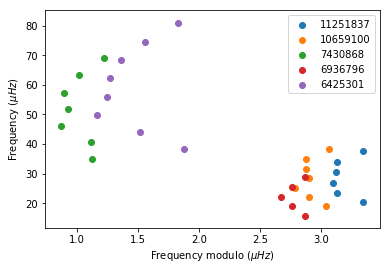

In [67]:
for i in IDs:   
    echelle(stardat, modes, i)
    
    '''n = l0modes.n
    epsilon = 0.4
    nmax = numax_obs/dnu_obs - epsilon
    k = 0.1
    A = 0.2
    w = 3
    tau = 8
    phi = 0
    f = model(n, dnu_obs, nmax, epsilon, k, A, w, tau, phi)
    plt.plot(f % dnu_obs, f, label = str(IDs[i])+'model')'''
    

plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
plt.legend()
#plt.xlim(3.0, dnu_obs)

In [68]:
'''plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'Data') 
plt.plot(f % dnu_obs, f, label = 'Model')
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
#mod_err = (l0modes.f0 % dnu_obs)*np.sqrt((dnu_obs_err/dnu_obs)**2 + (l0modes.f0_err/l0modes.f0)**2)
plt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')
plt.legend()'''

"plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'Data') \nplt.plot(f % dnu_obs, f, label = 'Model')\nplt.xlabel(r'Frequency modulo ($\\mu Hz$)')\nplt.ylabel(r'Frequency ($\\mu Hz$)')\n#mod_err = (l0modes.f0 % dnu_obs)*np.sqrt((dnu_obs_err/dnu_obs)**2 + (l0modes.f0_err/l0modes.f0)**2)\nplt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')\nplt.legend()"

In [69]:
code = '''
data {
    int N;
    real n[N];
    real freq[N];
    real freq_err[N];
    real dnu_guess;
}
parameters {
    real dnu;
    real epsilon;
    real nmax;
    real k;
    real<lower = 0> A;
    real<lower = 0, upper = 1.5> w;
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi;
    real<lower = 0> tau;
}
model {
    real mod[N];
    for (i in 1:N){
        mod[i] = (n[i] + epsilon) * dnu + k * (nmax - n[i])^2 + 
            A * exp(-n[i]/tau) * sin(n[i] * w + phi);
    }
    mod ~ normal(freq, freq_err);
    dnu ~ normal(dnu_guess, dnu_guess*0.001);
    epsilon ~ normal(1.0, 0.3);
    epsilon ~ uniform(-1.0, 2.0);
    nmax ~ normal(20, 4);
    k ~ lognormal(log(0.1), 0.3);
    A ~ lognormal(log(1), 0.4);
    w ~ normal(0.8, 0.1);
    tau ~ normal(50, 10);
}
generated quantities{
    real fm[N];
    for (j in 1:N){
        fm[j] = (n[j] + epsilon) * dnu + k * (nmax - n[j])^2 + 
            A * exp(-n[j]/tau) * sin(n[j] * w + phi);
    }
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9c447c93b58b94cf47f14613c64c8a71 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpx74lk92g/stanfit4anon_model_9c447c93b58b94cf47f14613c64c8a71_2266244592247187319.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [82]:
fits = {}
for i in IDs:
    dat_star = stardat.loc[stardat['ID'] == i]
    df_star = modes[str(i)]
    df_star = df_star.sort_values(by=['f0'])
    dnu_obs = np.mean(df_star.dnu)
    numax_obs = float(dat_star.loc[dat_star['ID'] == i].Numax)
    df_star = df_star.set_index(np.arange(0, len(df_star.f0), 1))
    nmax_guess = np.mean(df_star.n)
    epsilon_obs = np.median((df_star.f0 % dnu_obs) / dnu_obs)
    
    data = {'N': len(df_star.f0), 'n': df_star.n.values, 'freq': df_star.f0.values,
            'freq_err': df_star.f0_err.values, 'dnu_guess': dnu_obs}
    start = {'dnu': dnu_obs, 'epsilon': epsilon_obs, 
             'nmax': numax_obs/dnu_obs - epsilon_obs, 'k': 0.1, 'A': 1.0,
             'w': 0.8, 'phi': 2.0, 'tau': 50}
    nchains=4
    fit = sm.sampling(data=data, iter=5000, chains=nchains, init=[start for n in range(nchains)])
    fits[str(i)] = fit
    output = pd.DataFrame({'dnu': fit['dnu'], 'nmax': fit['nmax'], 'epsilon': fit['epsilon'], 
                           'k': fit['k'], 'A': fit['A'], 'w': fit['w'], 'phi': fit['phi'], 'tau': fit['tau']})
    #output.to_csv('samples_' + str(i) + '.csv')

In [83]:
for i in IDs:
    print('ID = ' + str(i))
    print(fits[str(i)])

ID = 3527032
Inference for Stan model: anon_model_9c447c93b58b94cf47f14613c64c8a71.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.55  5.6e-5 4.5e-3   4.54   4.55   4.55   4.56   4.56   6558    1.0
epsilon  -0.05  6.7e-4   0.03  -0.13  -0.07  -0.05  -0.03-1.2e-3   2155    1.0
nmax      9.17  3.5e-3    0.2   8.74   9.06   9.18   9.29   9.52   3103    1.0
k         0.07  2.2e-4   0.01   0.05   0.06   0.07   0.08    0.1   2611    1.0
A         0.49  3.5e-3   0.17   0.24   0.37   0.46   0.58   0.89   2165    1.0
w         0.53  1.3e-3   0.07    0.4   0.49   0.53   0.58   0.67   2633    1.0
phi       3.11    0.01   0.66   1.78   2.67    3.1   3.55   4.41   2487    1.0
tau       47.7    0.14  10.63  26.45   40.8  47.79  54.84  68.12   5846    1.0
fm[1]    27.84  1.2e-4   0.01  27.81  27.83  27.84  27.85  27.86   9382    1.0
fm[2]  

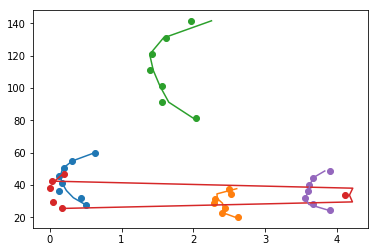

In [84]:
for i in IDs:
    stanfit = model(modes[str(i)].n, fits[str(i)]['dnu'].mean(), fits[str(i)]['nmax'].mean(), fits[str(i)]['epsilon'].mean(), fits[str(i)]['k'].mean(), fits[str(i)]['A'].mean(), fits[str(i)]['w'].mean(), fits[str(i)]['tau'].mean(), fits[str(i)]['phi'].mean())
    stan_dnu = fits[str(i)]['dnu'].mean()
    echelle(stardat, modes, i, True, stanfit, stan_dnu)